# Determination of $M^2$ beam quality factor 

This code was written to estimate the $M^2$ beam quality factor of a laser based on experimental data. The experiment was conducted as follows:
* A HeNe laser's beam was put through a focusing lens
* A CMOS camera was used to capture the beam's intensity pattern at various displacements from the focusing lens 

The basic function of this code is as follows:
* Read in a series of images containing the intensity profiles
* Perform simple averaging denoising on the images
* Perform gaussian fitting on the x and y lines passing through the center of the beam spot of each image using the following formula:
\begin{equation}
I(x) = A e^{-2(x - B)^2/C ^2} + D
\end{equation}
* Extract the 1/e^2 radius for fits and perform fit according to caustic formula
\begin{equation}
w^2(z) = w_0 ^2 + (M^2)^2 \big( \frac{\lambda}{\pi w_0} \big)^2 (z - z_0)^2
\end{equation}
* Extract M^2 value from fit and plot measured widths and fits vs displacement from focusing lens

This code was inpired by a MATLAB program provided during a lab course at Friedrich-Schiller-University Jena, but it has been completely re-structured and re-written -- this version is both more full-featured and more concise, containing less than half of the number of lines of code.

In [35]:
from imageio import imread
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage.filters import convolve

In [36]:
path = "180222_G3" #The folder which contains the image files
ext = ".jpg" #extension of the images
files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))
         and f[-len(ext):] == ext] #Returns a list of all files of given extension in the selected folder
files = sorted(files)
calibration = imread(path + "/calibration/00.jpg",pilmode="F")
images = [(imread(path + "/"+ f,pilmode="F")
           - calibration.astype(float)) for f in files]
          #Read all image files into a single list, remove static noise
leny,lenx = calibration.shape

In [37]:
#size = 2 #simple averaging noise removal
#B = np.ones((size, size))
#B /= B.sum()
#images = [convolve(image.astype(np.float32), B) for image in images] # simple box filter

images = [gaussian_filter(image,sigma = 0.5) for image in images] #gaussian filter to remove noise

In [38]:
mindicies = [np.unravel_index(image.argmax(),image.shape) 
             for image in images]                         #returns a list of tuples containing 
                                                          #the incicies of the horizontal and 
                                                          #verticle lines whose sum is largest
                                                          #(i.e the indicies of the center of the spot)

In [39]:
testwidth = 100
wavelength = 632.8e-9 #in m
M2_guess = 1.2
z0_guess = 20e-3
def gaussian(var,x,y): #Equation of a 2-d Gaussian for lsq
    return var[0] * np.exp(-2 * ((x-var[1]) / var[2])**2) - y + var[3]

def caustic(var,z,y): #Equation of the beam caustic for lsq
    return np.sqrt(var[0]**2 + ((var[1]*(wavelength)*(z-var[2]))/(np.pi*var[0]))**2) - y

def lsq_gauss(line): #lsq function for gaussian
    return least_squares(gaussian,[np.max(line),np.argmax(line),testwidth,np.min(line)]
                         ,loss = "soft_l1",f_scale=0.1,max_nfev = 1000,args = (np.arange(len(line)),line))
                            
def lsq_caustic(radii): #lsq function for beam caustic
    return least_squares(caustic, [np.average(radii),M2_guess,z0_guess]
                         ,loss = "soft_l1",f_scale=0.1,args = (z,radii),max_nfev = 1000)

In [40]:
fits = [(lsq_gauss(image[index[0]]),
         lsq_gauss(image.T[index[1]])) for image,index in zip(images,mindicies)]
                                                                #returns a list of tuples 

In [41]:
            #data was recorded with a variable step size in z,
            #thus we must define the step sizes used in order
            #to create the z vector
step1 = 5 #step sizes in mm
step2 = 10
step3 = 50

numsteps1 = 20 #number of data points (i.e. images)
               #for each step size
numsteps2 = 10
numsteps3 = 5

z = step1*np.arange(0,numsteps1)
z = np.concatenate((z,step2*np.arange(1,(numsteps2 + 1)) + z[-1]))
z = np.concatenate((z,step3*np.arange(1,(numsteps3 + 1)) + z[-1]))
z = z*1e-3 #convert to meter

In [42]:
pixel_pitch = 5.2e-6 #in meter
radii = [np.array([fit[0].x[2],fit[1].x[2]]) for fit in fits]
radii = np.abs(pixel_pitch*np.asarray(radii)) #convert to np array,
                                              #convert num pixels to meters
caustic_fits = [lsq_caustic(radii[:,0]),lsq_caustic(radii[:,1])]

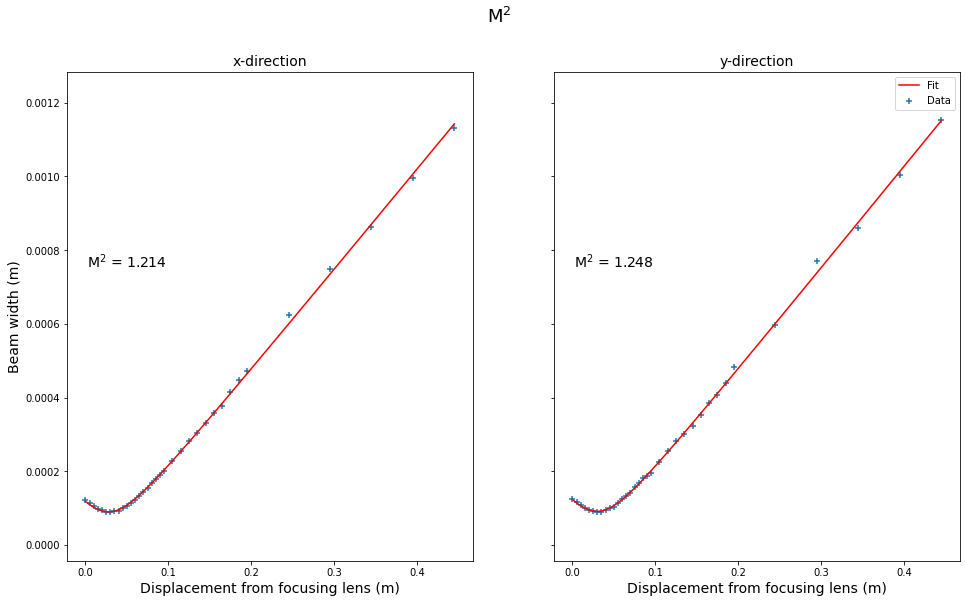

In [43]:
numdec = 5 #the number of decimals of the M^2 value to display -2
params = [{'mathtext.default': 'regular' },{'axes.titlesize': '14' }
          ,{'axes.labelsize': '14' },{'figure.titlesize': '18' }
          ,{'scatter.marker': '+' }]          
for param in params:
    plt.rcParams.update(param) #initial plot parameters

f, ax = plt.subplots(1, 2, sharey=True)
f.suptitle("$M^{2}$")
f.set_size_inches(16, 9)
axislabels = ["x-direction","y-direction"]

for i in np.arange(len(caustic_fits)):
    ax[i].set_title(axislabels[i])
    ax[i].scatter(z,radii[:,i], label = "Data")
    ax[i].plot(z,caustic(caustic_fits[i].x[:4],z,0),c = "red",label = "Fit")
    ax[i].text(0.05,0.6,"$M^{2}$ = " + str(caustic_fits[i].x[1])[:numdec]
               ,fontsize = 14,transform=ax[i].transAxes)
    ax[i].set_xlabel("Displacement from focusing lens (m)")

rmin = np.min(radii)
rmax = np.max(radii)
rint = rmax - rmin
plt.ylim(rmin - rint/8,rmax + rint/8) #Setup y-axis window
ax[0].set_ylabel("Beam width (m)")
plt.legend()
#plt.savefig("M^2.eps",format = "eps")
plt.show()

In [44]:
m2avg = (caustic_fits[0].x[1] + caustic_fits[1].x[1])/2
print("The average M^2 value is " + str(m2avg)[:numdec])

The average M^2 value is 1.231
